# Species abundance model for the Northeast Continental Shelf region 
### Description:
This notebook was created at the PACE Hackweek 2025. We created a tutorial for running a marine-specific species abundance model in Python. Our use-case will be with fisheries data collected on the [NOAA NEFSC bottom trawl](https://www.fisheries.noaa.gov/new-england-mid-atlantic/science-data/2025-spring-bottom-trawl-survey-completed-northeast) survey. 

### Authors (alphabetical): 
* Artem Dzhulai (URI)
* Eli Holmes (NOAA Fisheries) 
* Sajna Hussain (Oregon State)
* Jamon Jordan (Oregon State)
* Natalie McCourt (UMBC)
* Haley Synan (NOAA Fisheries/IBSS)

### History:
>* *8/4/25: notebook initialized, code added to stream pace and glorys data*
>* *8/5/25: pace match functions added, glorys matchup functions added*
>* *8/6/25: added code to fill nans with monthly data, added code from Ryan vandermeulen*


##### To get push access to SDM repo:
CD to local repo directory. Run ```gh-scoped-creds``` in the terimal and follow instructions.

## Contents 
1. [Work with fisheries Data](#1.-Work-with-fisheries-data)
2. [Load and match PACE Data](#2.-Load-and-match-PACE-data)
3. [Load and match GLORYS Data](#3.-Load-and-match-GLORYS-data)
4. [Create SDM model!](#4.-Create-SDM-model!)
5. [Visualize results](#5.-Visualize-results)

In [2]:
!pip install copernicusmarine

  Using cached copernicusmarine-2.2.1-py3-none-any.whl.metadata (8.2 kB)
  Using cached arcosparse-0.4.2-py3-none-any.whl.metadata (5.2 kB)
  Using cached h5netcdf-1.6.4-py3-none-any.whl.metadata (13 kB)
  Using cached semver-3.0.4-py3-none-any.whl.metadata (6.8 kB)
  Using cached pyarrow-21.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached copernicusmarine-2.2.1-py3-none-any.whl (115 kB)
Using cached arcosparse-0.4.2-py3-none-any.whl (26 kB)
Using cached h5netcdf-1.6.4-py3-none-any.whl (50 kB)
Using cached semver-3.0.4-py3-none-any.whl (17 kB)
Using cached pyarrow-21.0.0-cp311-cp311-manylinux_2_28_x86_64.whl (42.8 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 15.0.2
    Uninstalling pyarrow-15.0.2:
      Successfully uninstalled pyarrow-15.0.2
  Attempting uninstall: h5netcdf
    Found existing installation: h5netcdf 1.3.0
    Uninstalling h5netcdf-1.3.0:
      Successfully uninstalled h5netcdf-1.3.0


In [4]:
!pip install cmocean

  Using cached cmocean-4.0.3-py3-none-any.whl.metadata (4.2 kB)
Using cached cmocean-4.0.3-py3-none-any.whl (421 kB)


In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import xarray as xr
import earthaccess
from match_func import match_nearest
import netCDF4
import h5netcdf
import math
import copernicusmarine
import geopandas as gpd
import earthaccess
import xarray as xr
import cartopy.feature as cfeature
from shapely.ops import unary_union
from tqdm import tqdm
import cmocean
auth = earthaccess.login(persist=True)

## 1. Work with fisheries data

In [6]:
#os.chdir(r'/home/jovyan/Hackweek2025/proj_2025_sdm/data')
#trawl_df = pd.read_csv('fisheries_with_pace_rrs_avw2.csv') #read data 
trawl_df = pd.read_csv('/home/jovyan/proj_2025_sdm/data/fisheries_with_pace_rrs_avw2.csv') #read data 

# Ensure the date column is a proper datetime object.
trawl_df['TOWDATETIME_EST'] = pd.to_datetime(trawl_df['TOWDATETIME_EST'])

# Ensure coordinates are numeric
trawl_df['LON'] = pd.to_numeric(trawl_df['LON'])
trawl_df['LAT'] = pd.to_numeric(trawl_df['LAT'])

# Display the first few rows and data types to verify
print("Catch Data Head:")
print(trawl_df.head())
print("\nData Types:")
print(trawl_df.info())

# --- Standardize Column Names to Match Xarray Dims ---
# This is the crucial step to ensure congruency.
rename_dict = {
    'TOWDATETIME_EST': 'time',
    'LAT': 'latitude',
    'LON': 'longitude'
}
trawl_df = trawl_df.rename(columns=rename_dict)

Catch Data Head:
      TOWDATETIME_EST        LAT        LON  MEAN_DEPTH  SWEPT_AREA_km  \
0 2024-03-07 10:58:00  38.659194 -74.828083          24       0.021282   
1 2024-03-07 14:32:00  38.498596 -74.477395          40       0.024311   
2 2024-03-07 17:44:00  38.411974 -74.502885          39       0.023835   
3 2024-03-07 20:29:00  38.505238 -74.832046          25       0.021510   
4 2024-03-07 22:45:00  38.556784 -74.897495          21       0.019174   

   acadian redfish  alewife  alligatorfish  american lobster  american plaice  \
0              0.0      0.0            0.0               0.0              0.0   
1              0.0      0.0            0.0               0.0              0.0   
2              0.0      0.0            0.0               0.0              0.0   
3              0.0      0.0            0.0               1.0              0.0   
4              0.0      0.0            0.0              27.0              0.0   

   ...   Rrs_707   Rrs_708   Rrs_709   Rrs_711   Rr

## Data exploration
We want to find a species (or few) that would be the most useful to model. We will sort the species by total number of observations over the entire survey. We will plot the 6 most common species as a faux time series, using station number instead of datetime. Then we will find species that have more than 50,000 observations over the survey period. This is a crude way to remove the species that were rarely seen and wouldn't be a good fit to model. 

/tmp/ipykernel_186/79794507.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['station'] = np.arange(1,len(sub)+1) #add station col


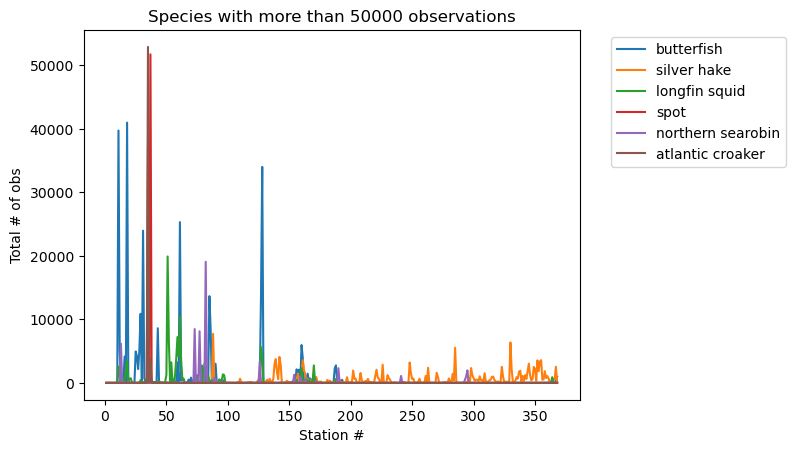

In [7]:
matched=[]
for item in trawl_df.columns:
    if 'Rrs' in item:  # Using the 'in' operator for substring check
        pass
    else: 
        matched.append(item)

sub = trawl_df[list(matched)] #subset (remove RRS columns) 
sub['station'] = np.arange(1,len(sub)+1) #add station col

tot_sum = {}
for s in sub.columns[5:-2]:
   tot_sum.update({s:int(sub[s].sum())})  #get total sum of all values 

sorted_tot_sum = sorted(tot_sum.items(), key=lambda item: item[1],reverse=True) #sort by max-->min


abu=[]
for val in sorted_tot_sum:
    if val[1]>50000: #if more than 50000 observations 
        abu.append(val[0])


#plot max valeus 
for s in sub[abu].columns:
    plt.plot(sub.station, sub[s],label=s)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )
plt.xlabel('Station #')
plt.ylabel('Total # of obs')
plt.title('Species with more than 50000 observations')
plt.show()

Now we have the 6 most dominant (in total # of obs) over the survey period. We 

In [ ]:
min_lat = trawl_df['latitude'].min()
max_lat = trawl_df['latitude'].max()
min_lon = trawl_df['longitude'].min()
max_lon = trawl_df['longitude'].max()

# Print DataFrame shape and columns (for trawl_df)
print("\n--- Trawl Data Shape and Columns ---")
print("Trawl DataFrame Shape:", trawl_df.shape)
#print("Trawl DataFrame Columns:", trawl_df.columns.tolist())


print(f"Trawl data latitude range: {min_lat} to {max_lat}")
print(f"Trawl data longitude range: {min_lon} to {max_lon}")
print("Trawl Data Time Range:", trawl_df["time"].min(), "to", trawl_df["time"].max())

In [ ]:
# Create a figure and a 3x2 grid of subplots
bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))
fig, axs = plt.subplots(2, 3, figsize=(12, 8),subplot_kw={'projection': cartopy.crs.PlateCarree()}) 

# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten() 

# Example data for plotting
x = np.linspace(0, 10, 100)

# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    ax.scatter(sub[sub[sub[abu].columns[i]]==0].longitude, sub[sub[sub[abu].columns[i]]==0].latitude,c='r',s=8,label='Absence')
    ax.scatter(sub[sub[sub[abu].columns[i]]!=0].longitude, sub[sub[sub[abu].columns[i]]!=0].latitude,c='g',s=8,label='Presence')
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    ax.add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask 
    ax.add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    ax.add_feature(cfeature.OCEAN, facecolor='azure')
    ax.set_title(sub[abu].columns[i])
    ax.legend()
fig.suptitle('Species presence by station')

## 2. Load and match PACE data
We will be using chlorophyll, avw, and RRS brightness

In [8]:
def get_pace_path(trawl_df, short_name):
    tspan = (trawl_df.date.min(), trawl_df.date.max())
    bbox = (-76.75, 33, -63, 46) #west,south,east,north
    #clouds = (0, 50)
    results = earthaccess.search_data(
        short_name=short_name,
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.8*.4km*")
        #cloud_cover=clouds,
    paths = earthaccess.open(results)
    return paths 


def open_pace(paths): 
    d8=[]
    for file in paths: 
        d = xr.open_dataset(file)
        d8.append(d.attrs['time_coverage_start'])
    ds = xr.open_mfdataset(paths, combine='nested',concat_dim='datetime').assign_coords({'time':d8}) #add new dimension and assign time data to it
    ds = ds.rename({'datetime':'time'}) #rename to time
    ds = ds.where((ds.lat > 34.40918) & (ds.lat < 46.362305) & (-63>ds.lon) & (-77< ds.lon),drop=True) #general spatial subset
    ds = ds.rename({'lat':'latitude','lon':'longitude'})
    #ds['time']=[pd.to_datetime(d) for d in ds.time.values] #convert to pandas datetime 
    ds['time'] = pd.to_datetime(ds.time) #convert to pandas datetime 
    return ds

#trawl_df pre-processing
trawl_df['date'] = [str(d).split(' ')[0] for d in trawl_df.time] 
#trawl_df['time'] = [pd.to_datetime(d.replace(' ','T')) for d in trawl_df.TOWDATETIME_EST] #format as timestamp

#get pace data 
paths_avw= get_pace_path(trawl_df,"PACE_OCI_L3M_AVW")
paths_chl= get_pace_path(trawl_df,"PACE_OCI_L3M_CHL")
paths_kd= get_pace_path(trawl_df,"PACE_OCI_L3M_KD")


ds_avw, ds_chl = list(map(open_pace,[paths_avw, paths_chl])) #get path values for each variable 

#match data 
data=[ds_avw, ds_chl] #list of datasets
var_names =['avw','chlor_a'] #list of variable names 
for d in range(len(data)): 
    if d == 0: 
        trawl_df = match_nearest(trawl_df,data[d],var_names[d],var_names[d],date=trawl_df.time) #get full trawl_df + avw 
    else: 
        trawl_df[var_names[d]]=match_nearest(trawl_df,data[d],var_names[d],var_names[d],date=trawl_df.time)[var_names[d]] #add chl in 
    
# Check for any missing values, which could indicate a mismatch
#print("\nMissing values count:")
#print(trawl_df[['avw','chlor_a'].isnull().sum())

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

AttributeError: 'Dataset' object has no attribute 'longitude'

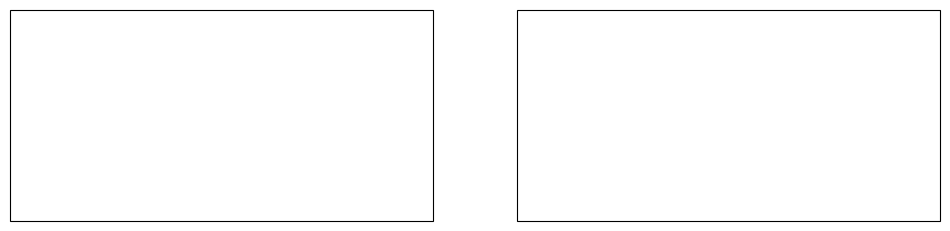

In [59]:
bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))

for i in range(2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6),subplot_kw={'projection': cartopy.crs.PlateCarree()}) 

    im=axs[0].pcolormesh(ds_avw.longitude, ds_avw.latitude, ds_avw.avw[i],cmap=cmocean.cm.solar)
    axs[0].add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    axs[0].add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask
    axs[0].add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    axs[0].set_title('Apparent visible wavelength')
    
    im1=axs[1].pcolormesh(ds_chl.longitude, ds_chl.latitude, ds_chl.chlor_a[i],cmap=cmocean.cm.algae)
    axs[1].add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    axs[1].add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask
    axs[1].add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    axs[1].set_title('Chlorophyll')
    
    fig.colorbar(im, ax=axs[0],shrink=0.65)
    fig.colorbar(im1, ax=axs[1],shrink=0.65)
    fig.suptitle('PACE Variables: '+ str(ds_avw.time[i].values).split('T')[0],y=0.85)
    fig.show()


After matching 8-day PACE data, we still have some NAN values. Lets try to grab monthly data to fill them in

In [ ]:
isna= [math.isnan(d) for d in trawl_df.avw]
fig = plt.figure(figsize=(10, 7)) #set figure size
map_projection = cartopy.crs.PlateCarree() #set map projection
ax = plt.axes(projection=map_projection) 
plt.pcolormesh(ds_chl.longitude, ds_chl.latitude, ds_chl.chlor_a[0],cmap=cmocean.cm.algae)
plt.scatter(trawl_df[isna][:20].longitude, trawl_df[isna][:20].latitude,s=8,c='r')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
ax.add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask
ax.add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
plt.title('8-Day chlor_a \n Visualize missing data after matchup')

In [9]:
def get_pace_nan_replace(trawl_df, short_name):
    #used to address NaN values to allow for more robust data
    tspan = (trawl_df.date.min(), trawl_df.date.max())
    bbox = (-76.75, 33, -63, 46) #west,south,east,north
    #clouds = (0, 50)
    results = earthaccess.search_data(
        short_name=short_name,
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.M*.4km*") #update to month
        #cloud_cover=clouds,
    paths = earthaccess.open(results)
    return paths 

def extract_scalar(val): 
    #since avw values are objects, this function extracts the 
    #actual, usable scalar value (a float)
    if isinstance(val, (list, np.ndarray)): #checks if instance of a list or a NumPy list
        if np.size(val)== 1:
            return val[0] if isinstance(val, list) else val.item()
        else:
            return np.nan 
    elif hasattr(val, 'item'): #unwraps from NumPy object, xarray scalar DataArray, etc.
        try:
            return val.item()
        except:
            return np.nan
    return val

#converting datatype to usable float64
trawl_df['avw'] = trawl_df['avw'].apply(extract_scalar)
trawl_df['chlor_a'] = trawl_df['chlor_a'].apply(extract_scalar)

trawl_df['avw'] = pd.to_numeric(trawl_df['avw'], errors='coerce') #another conversion to float
trawl_df['chlor_a'] = pd.to_numeric(trawl_df['chlor_a'], errors='coerce') #another conversion to float

#creating list of indices containing NaN values
na_index_avw = trawl_df[trawl_df.avw.isna()].index 
na_index_chl = trawl_df[trawl_df.chlor_a.isna()].index

#creates dataset containing only NaN values
trawl_df_avw_nan_only = trawl_df.loc[na_index_avw] 
trawl_df_chl_nan_only = trawl_df.loc[na_index_chl] 

trawl_df_avw_nan_only = trawl_df_avw_nan_only.drop('avw', axis = 1)
trawl_df_chl_nan_only = trawl_df_chl_nan_only.drop('chlor_a', axis = 1)

nan_avw_path = get_pace_nan_replace(trawl_df,"PACE_OCI_L3M_AVW")
nan_chl_path = get_pace_nan_replace(trawl_df,"PACE_OCI_L3M_CHL")

nan_avw_ds, nan_chl_ds = list(map(open_pace,[nan_avw_path, nan_chl_path])) #get path values for each variable 

matched_monthly = match_nearest(trawl_df_avw_nan_only.reset_index(), nan_avw_ds, 'avw', 'avw', date=trawl_df_avw_nan_only.time)
trawl_df.loc[na_index_avw, 'avw'] = matched_monthly['avw']

matched_monthly = match_nearest(trawl_df_chl_nan_only.reset_index(), nan_chl_ds, 'chlor_a', 'chlor_a', date=trawl_df_chl_nan_only.time)
trawl_df.loc[na_index_chl, 'chlor_a'] = matched_monthly['chlor_a']


QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_186/122521124.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[array(506.46768, dtype=float32) array(516.4573, dtype=float32)
 array(525.9102, dtype=float32) array(523.07153, dtype=float32)
 array(520.1844, dtype=float32) array(513.85474, dtype=float32)
 array(508.65836, dtype=float32) array(506.40588, dtype=float32)
 array(505.79227, dtype=float32) array(507.4457, dtype=float32)
 array(505.6985, dtype=float32) array(507.77792, dtype=float32)
 array(504.23615, dtype=float32) array(506.19116, dtype=float32)
 array(506.81433, dtype=float32) array(505.57782, dtype=float32)
 array(503.9149, dtype=float32) array(503.9149, dtype=float32)
 array(503.66803, dtype=float32) array(505.3281, dtype=float32)
 array(524.42834, dtype=float32) array(510.89914, dtype=float32)
 array(522.3358, dtype=float32) array(518.92633, dtype=float32)
 array(508.19528, dtype=float32) array(500.8488, dtype=float32) 

In [8]:
print(f'After matching to month, there are still {str(len(trawl_df[[math.isnan(d) for d in trawl_df.avw]]))} nans values that will need to be dropped from the dataset, resulting in a total of {str(len(trawl_df)-43)} study points ')

After matching to month, there are still 43 nans values that will need to be dropped from the dataset, resulting in a total of 325 study points 


## Calculate RRS brightness
* **CODE WRITTEN BY RYAN VANDERMEULEN** who graciously let us steal it for this project.
  * THANKS RYAN :D
* RRS brightness is calculated usign a numerical integration using the trapezoidal rule of the Rrs values between 400-700 nm and is measures the total amount of brightness from the water

In [ ]:
df = trawl_df.drop([col for col in trawl_df.columns if 'Rrs' in col],axis=1)
# === Helper: convert date to 8-day PACE period ===
def get_8day_range(date_str):
    dt = pd.to_datetime(date_str)
    doy = (dt - pd.Timestamp("2024-01-01")).days
    start_day = 8 * (doy // 8)
    start_date = pd.Timestamp("2024-01-01") + pd.Timedelta(days=start_day)
    end_date = start_date + pd.Timedelta(days=7)
    return start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")

# === Caching logic ===
rrs_cache = {}
avw_cache = {}

def load_cached_dataset(short_name, start_date, end_date, cache, product_type="8D"):
    key = (short_name, start_date, product_type)
    if key in cache:
        return cache[key]

    granule_pattern = f"*.{product_type}.*.4km.*"

    results = earthaccess.search_data(
        short_name=short_name,
        temporal=(start_date, end_date),
        granule_name=granule_pattern
    )
    if not results:
        return None

    try:
        ds = xr.open_dataset(earthaccess.open(results)[0])
        cache[key] = ds
        return ds
    except Exception as e:
        print(f"Failed to open dataset for {short_name} on {start_date} ({product_type}): {e}")
        return None

def try_extract(ds_rrs, ds_avw, lat, lon):
    if ds_rrs is None or ds_avw is None:
        return None, None, None

    try:
        lat_idx = np.abs(ds_rrs["lat"].values - lat).argmin()
        lon_idx = np.abs(ds_rrs["lon"].values - lon).argmin()

        lat_slice = slice(max(lat_idx - 2, 0), min(lat_idx + 3, ds_rrs.sizes["lat"]))
        lon_slice = slice(max(lon_idx - 2, 0), min(lon_idx + 3, ds_rrs.sizes["lon"]))

        rrs_vals = ds_rrs["Rrs"][lat_slice, lon_slice, :].mean(dim=("lat", "lon")).values
        avw_val = ds_avw["avw"][lat_slice, lon_slice].mean().item()
        wavelengths = ds_rrs["wavelength"].values

        return rrs_vals, avw_val, wavelengths

    except Exception as e:
        print(f"Error extracting Rrs/AVW: {e}")
        return None, None, None

# === Main loop ===
rrs_data = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    tow_date = row["time"]
    lat, lon = row["latitude"], row["longitude"]
    start_date, end_date = get_8day_range(tow_date)

    # === Try 8-day first ===
    ds_rrs = load_cached_dataset("PACE_OCI_L3M_RRS", start_date, end_date, rrs_cache, product_type="8D")
    ds_avw = load_cached_dataset("PACE_OCI_L3M_AVW", start_date, end_date, avw_cache, product_type="8D")
    rrs_vals, avw_val, wavelengths = try_extract(ds_rrs, ds_avw, lat, lon)

    # === Fallback to monthly if 8-day fails or is all NaNs ===
    if rrs_vals is None or np.all(np.isnan(rrs_vals)):
        monthly_start = pd.to_datetime(tow_date).replace(day=1)
        monthly_end = (monthly_start + pd.offsets.MonthEnd(0)).strftime("%Y-%m-%d")
        monthly_start = monthly_start.strftime("%Y-%m-%d")

        ds_rrs = load_cached_dataset("PACE_OCI_L3M_RRS", monthly_start, monthly_end, rrs_cache, product_type="MO")
        ds_avw = load_cached_dataset("PACE_OCI_L3M_AVW", monthly_start, monthly_end, avw_cache, product_type="MO")
        rrs_vals, avw_val, wavelengths = try_extract(ds_rrs, ds_avw, lat, lon)

        if rrs_vals is not None and not np.all(np.isnan(rrs_vals)):
            print(f"⚠️  Used monthly fallback for {tow_date}")
        else:
            print(f"❌ No valid Rrs data even in monthly fallback for {tow_date}")
            continue

    # === Store result ===
    result = {
        "time": tow_date,
        "AVW": avw_val
    }
    for wl, val in zip(wavelengths, rrs_vals):
        result[f"Rrs_{int(wl)}"] = val

    rrs_data.append(result)

# === Merge with fisheries data and save ===
rrs_df = pd.DataFrame(rrs_data)
merged = pd.merge(df, rrs_df, on="time", how="left")

# === Compute brightness from Rrs ===
rrs_cols = [col for col in merged.columns if col.startswith("Rrs_")]
rrs_wavelengths = [int(col.split("_")[1]) for col in rrs_cols]
rrs_filtered = [(wl, col) for wl, col in zip(rrs_wavelengths, rrs_cols) if 400 <= wl <= 700]
rrs_filtered.sort()
wavelengths, rrs_ordered_cols = zip(*rrs_filtered)

rrs_values = merged[list(rrs_ordered_cols)].values
rrs_brightness = np.trapz(rrs_values, x=wavelengths, axis=1)
trawl_df["rrs_brightness"] = rrs_brightness


## 3. Load and match GLORYS data

In [11]:
glorys_ds= copernicusmarine.open_dataset(dataset_id = 'cmems_mod_glo_phy_myint_0.083deg_P1D-m',minimum_longitude=-77, maximum_longitude=-63,minimum_latitude=34,maximum_latitude=46,)
glorys_subset = glorys_ds.where((glorys_ds['time.year'] > 2023) & (glorys_ds['time.month']>2)& (glorys_ds['time.month']<6), drop=True)
glorys_subset['time'] = [pd.Timestamp(d) for d in glorys_subset.time.values]

INFO - 2025-08-07T12:23:51Z - Selected dataset version: "202311"
INFO - 2025-08-07T12:23:51Z - Selected dataset part: "default"
INFO - 2025-08-07T12:23:51Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username:

  jjordan


Copernicus Marine password:

  ········


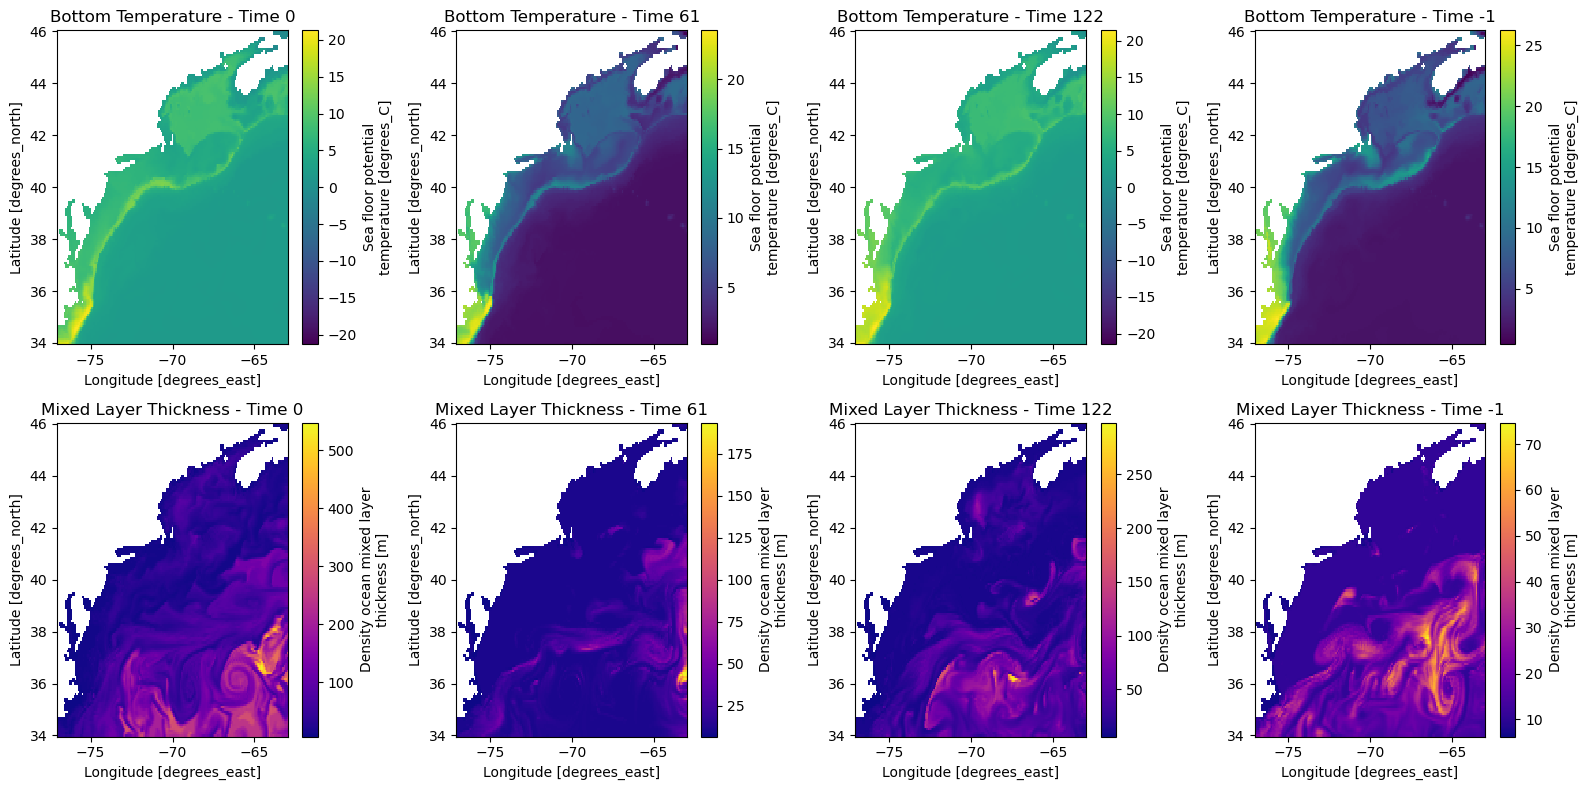

In [80]:
# Plot at multiple time slices to inspect data
# Select four time slices (modify indices if needed)
time_indices = [0, int(len(glorys_subset.time)/3), int(2*len(glorys_subset.time)/3), -1]

# Set up figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for i, t in enumerate(time_indices):
    # Plot 
    ax = axes[0, i]
    glorys_subset.bottomT.isel(time=t).plot(ax=ax, cmap="viridis")
    ax.set_title(f"Bottom Temperature - Time {t}")

    # Plot 2
    ax = axes[1, i]
    glorys_subset.mlotst.isel(time=t).plot(ax=ax, cmap="plasma")
    ax.set_title(f"Mixed Layer Thickness - Time {t}")

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
# --- Vectorized Extraction ---

# 1. Create DataArrays for coordinates from your standardized catch_df.
#    The names 'time', 'latitude', 'longitude' now match the env_ds dimensions.
times = xr.DataArray(trawl_df.time.values, dims="observation")
lats = xr.DataArray(trawl_df.latitude.values, dims="observation")
lons = xr.DataArray(trawl_df.longitude.values, dims="observation")

# 2. Extract the 3D variables (bottomT, mlotst) in one go.
#    These variables don't have a 'depth' dimension.
extracted_3d_data = glorys_subset[['bottomT', 'mlotst']].sel(
    time=times,
    latitude=lats,
    longitude=lons,
    method="nearest"
)

# 3. Handle the 4D variable (so) separately to deal with depth.
#    Since it's bottom trawl data, we select the deepest available grid cell.
#    .isel(depth=-1) selects the last element along the depth dimension.
extracted_so = glorys_subset['so'].sel(
    time=times,
    latitude=lats,
    longitude=lons,
    method="nearest"
).isel(depth=-1) # Select the bottom-most depth layer

# --- Merge results back into your original DataFrame ---

# Add the extracted 3D variables
trawl_df['bottom_temp'] = extracted_3d_data['bottomT'].values
trawl_df['mld'] = extracted_3d_data['mlotst'].values

# Add the extracted bottom salinity
trawl_df['bottom_salinity'] = extracted_so.values

# --- Display the final merged DataFrame ---
print("\n--- FINAL MERGED DATA ---")
# Displaying relevant columns for verification
final_columns = [
    'time', 'latitude', 'longitude', 'MEAN_DEPTH',
    'bottom_temp', 'mld', 'bottom_salinity'
]
print(trawl_df[final_columns].head())

# Check for any missing values, which could indicate a mismatch
print("\nMissing values count:")
print(trawl_df[final_columns].isnull().sum())


--- FINAL MERGED DATA ---
                 time   latitude  longitude  MEAN_DEPTH  bottom_temp  \
0 2024-03-07 10:58:00  38.659194 -74.828083          24     6.877743   
1 2024-03-07 14:32:00  38.498596 -74.477395          40     7.566973   
2 2024-03-07 17:44:00  38.411974 -74.502885          39     7.698813   
3 2024-03-07 20:29:00  38.505238 -74.832046          25     6.991272   
4 2024-03-07 22:45:00  38.556784 -74.897495          21     6.862362   

         mld  bottom_salinity  
0  10.528886              NaN  
1  10.834071              NaN  
2  10.528886              NaN  
3  10.528886              NaN  
4  10.528886              NaN  

Missing values count:
time                 0
latitude             0
longitude            0
MEAN_DEPTH           0
bottom_temp          1
mld                  1
bottom_salinity    368
dtype: int64


In [ ]:
bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))
fig, axs = plt.subplots(2, 3, figsize=(12, 6),subplot_kw={'projection': cartopy.crs.PlateCarree()}) 

# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten() 

var=['mld','bottom_temp','bottom_salinity','chlor_a','avw','Rrs_brightness']
var_n = ['Mixed layer depth','Bottom Temperature','Bottom Salinity','Chlorophyll a','AVW','RRS brightness']
# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    if var[i] == 'bottom_temp':
        cmap = cmocean.cm.thermal
    elif var[i] =='chlor_a':
        cmap=cmocean.cm.algae
    elif var[i] == 'Rrs_brightness':
        cmap=cmocean.cm.solar
    else: 
        cmap = cmocean.cm.deep
    im=ax.scatter(trawl_df.longitude, trawl_df.latitude, c=trawl_df[var[i]], label=var[i],s=8, cmap=cmap,vmin=trawl_df[var[i]].min(),vmax=trawl_df[var[i]].max(), )
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    ax.add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask 
    ax.add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    ax.add_feature(cfeature.OCEAN, facecolor='azure')
    fig.colorbar(im, ax=ax,shrink=0.95)
    ax.set_title(var_n[i])
fig.suptitle('Matched variables')

In [54]:
# --- Calculate CPUE for each target species ---
trawl_df['cpue_butterfish'] = trawl_df['butterfish'] / trawl_df['SWEPT_AREA_km']
trawl_df['cpue_squid'] = trawl_df['longfin squid'] / trawl_df['SWEPT_AREA_km']
trawl_df['cpue_hake'] = trawl_df['silver hake'] / trawl_df['SWEPT_AREA_km']
trawl_df['cpue_spot'] = trawl_df['spot'] / trawl_df['SWEPT_AREA_km'] # <-- ADDED THIS LINE

df = trawl_df.copy()

# assign variables of interest into lists
TARGET_SPECIES = ['cpue_butterfish', 'cpue_hake', 'cpue_squid', 'cpue_spot']
PREDICTOR_COLUMNS = ['avw', 'chlora_log10', 'MEAN_DEPTH', 'bottom_temp', 'mld', 'Rrs_brightness']

y = np.log1p(df[TARGET_SPECIES]) # standard parcatice for fisheries data
X_df = df[PREDICTOR_COLUMNS]

## 4. Create SDM model! 

In [35]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [ ]:
# --- Model Initialization ---

In [24]:
# define the core parameters.
xgb_reg = xgb.XGBRegressor(
    # --- Boosting Parameters (How the model learns) ---
    n_estimators=1000,         # Analogous to the "richness" of the model. Number of trees to build.
                               # We set this high and use early stopping to find the optimal number.
    learning_rate=0.05,        # Analogous to a shrinkage parameter. Lower values make the model more robust.

    # --- Tree Complexity Parameters ---
    max_depth=5,               # Analogous to `k` in s(x, k=...). Controls max interaction depth.
    min_child_weight=1,        # A form of regularization. Prevents learning highly specific patterns.
    gamma=0.1,                 # Analogous to `sp`. A value > 0 penalizes splits, making the model more conservative.
    subsample=0.8,             # Use 80% of data for building each tree. Adds randomness to fight overfitting.
    colsample_bytree=0.8,      # Use 80% of features for building each tree. Also for overfitting.

    # --- Regularization Parameters ---
    reg_alpha=0.005,           # L1 regularization on leaf weights.
    reg_lambda=1,              # L2 regularization on leaf weights.

    # --- Technical Parameters ---
    objective='reg:squarederror', # The loss function to optimize.
    n_jobs=-1,                 # Use all available CPU cores.
    random_state=42,           # For reproducibility.
    eval_metric='rmse'         # Metric to monitor during training.
)

print("Model initialized with parameters:")
print(xgb_reg.get_params())


--- Step 2: Initializing the XGBoost Model ---
Model initialized with parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'rmse', 'feature_types': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.005, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [ ]:
# --- Model Training ---

In [56]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False) # Set verbose=True to see the training progress

print(f"Model training complete.")

Model training complete.


In [57]:
results = xgb_reg.evals_result()
best_iteration = np.argmin(results['validation_0']['rmse'])
best_score = results['validation_0']['rmse'][best_iteration]

print(f"Best iteration found: {best_iteration}")
print(f"Best validation RMSE: {best_score:.4f}")

Best iteration found: 928
Best validation RMSE: 2.1054


In [ ]:
# --- Predict and evaluate ---

In [58]:
print("\n--- Step 4: Making Predictions ---")
predictions = xgb_reg.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f"Final RMSE on validation data: {rmse:.4f}")


--- Step 4: Making Predictions ---
Final RMSE on validation data: 2.1057


## 5. Visualize results


--- Step 5: Interpreting the Model ---
Plotting feature importance...


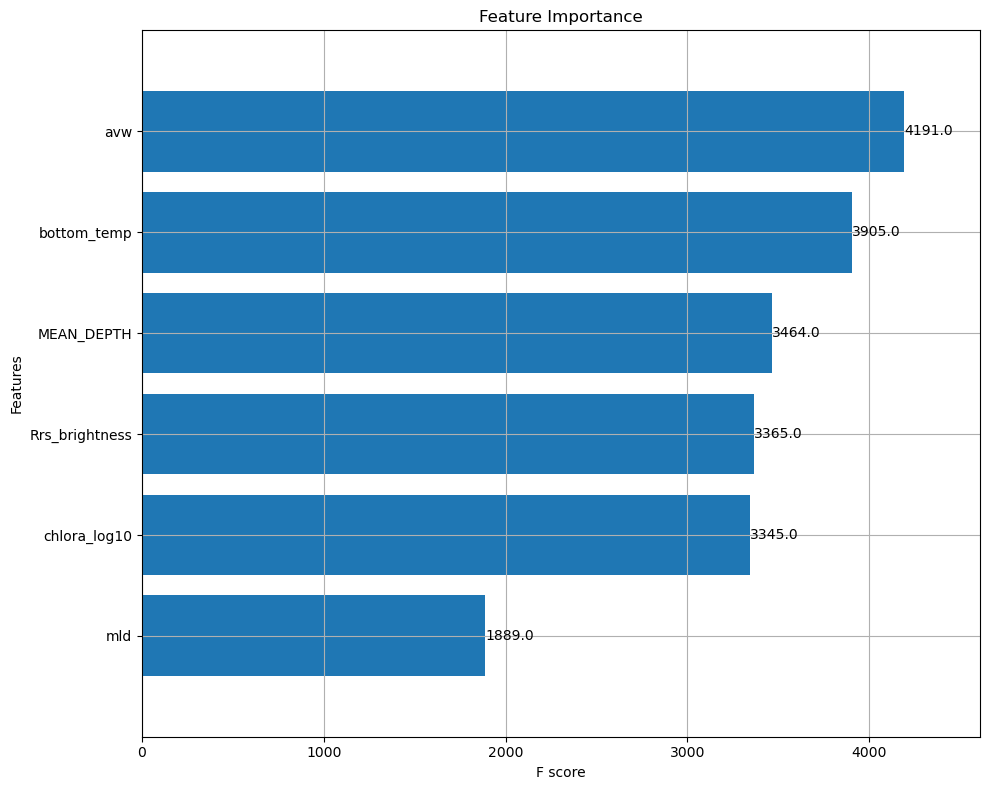

In [59]:
# Feature Importance plot
print("Plotting feature importance...")
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_reg, ax=ax, max_num_features=10, height=0.8, title="Feature Importance")
plt.tight_layout()
plt.show()

In [81]:
pip install shap
import shap

Note: you may need to restart the kernel to use updated packages.



Calculating and plotting SHAP values...


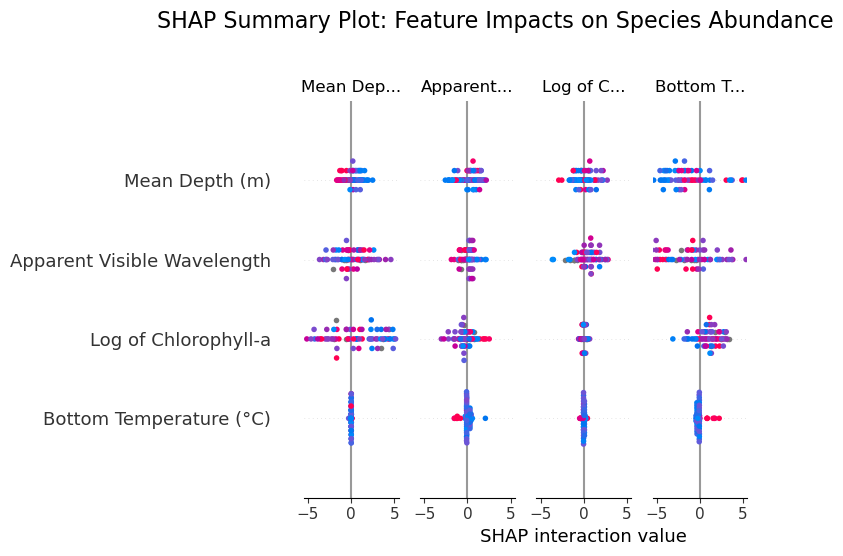

In [64]:
# --- SHAP Values ---

feature_name_map = {
    'avw': 'Apparent Visible Wavelength',
    'chlora_log10': 'Log of Chlorophyll-a',
    'MEAN_DEPTH': 'Mean Depth (m)',
    'bottom_temp': 'Bottom Temperature (°C)',
    'mld': 'Mixed Layer Depth (m)',
    'Rrs_brightness': 'Surface Reflectance'
}
# Create a temporary DataFrame with the clean names for plotting
X_val_renamed = X_val.rename(columns=feature_name_map)

print("\nCalculating and plotting SHAP values...")
explainer = shap.TreeExplainer(xgb_reg)
values = explainer.shap_values(X_val)

# draw the plot w/o plotting
shap.summary_plot(
    values,
    X_val_renamed, # Use the renamed features for a cleaner plot
    plot_type="dot",
    show=False,
    max_display=X_val_renamed.shape[1] # Ensure all features are shown
)

# 2. use .gcf to 'grab current figure'
fig = plt.gcf()

# 3. Add a title 
fig.suptitle("SHAP Summary Plot: Feature Impacts on Species Abundance", fontsize=16)

# 4. Adjust the layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# 5. display
plt.show()

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
# --- Step 9: Create Partial Dependence Plots ---
print(f"\n--- Creating Partial Dependence Plots for {TARGET_SPECIES} ---")

# The PDP shows the marginal effect one or two features have on the predicted outcome.
for i, species in enumerate(TARGET_SPECIES):
    print(f"\n--- Generating PDPs for: {species} ---")
    for predictor in PREDICTOR_COLUMNS:
        if predictor in X_train.columns:
            try:
                fig, ax = plt.subplots(figsize=(8, 6))
                PartialDependenceDisplay.from_estimator(
                    estimator=xgb_reg,
                    X=X_train,
                    features=[predictor],
                    target=i,  
                    ax=ax
                )
                ax.set_title(f"Partial Dependence Plot for {predictor}\n({species})")
                ax.set_ylabel("Partial Dependence (log CPUE scale)")
                plt.grid(True, linestyle='--', alpha=0.6)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not create PDP for {predictor} and {species}. Error: {e}")


--- Creating Partial Dependence Plots for ['cpue_butterfish', 'cpue_hake', 'cpue_squid', 'cpue_spot'] ---

--- Generating PDP grid for: cpue_butterfish ---


/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


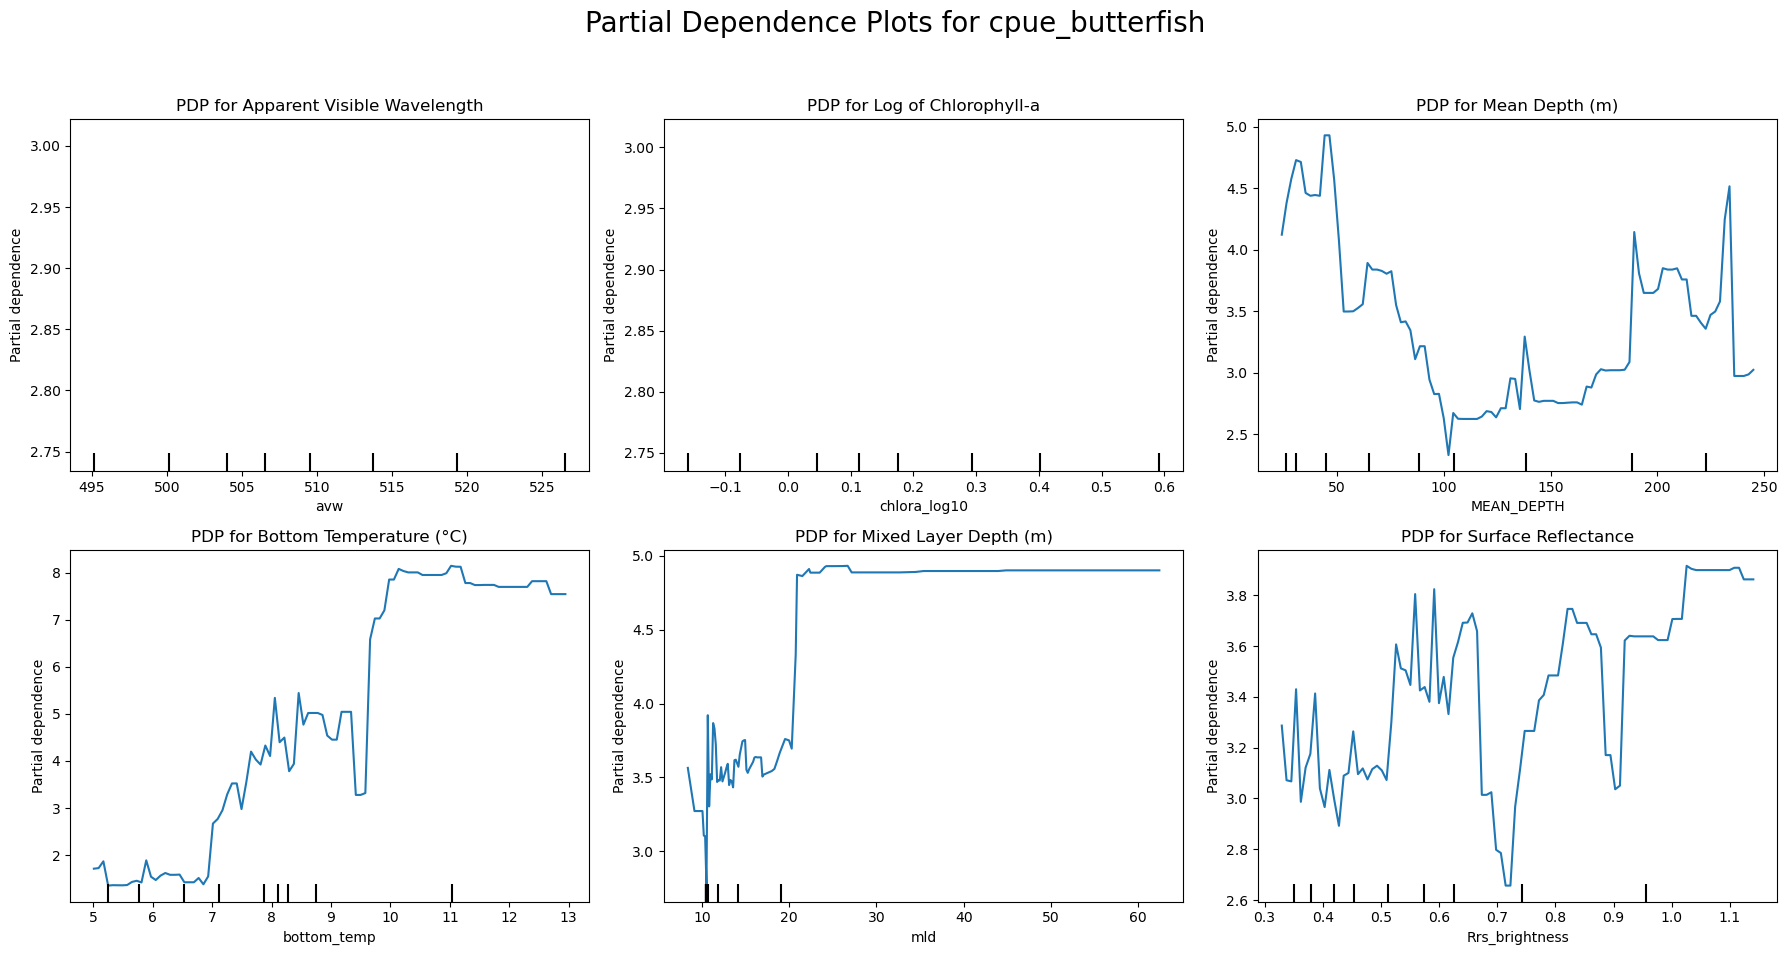


--- Generating PDP grid for: cpue_hake ---


/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


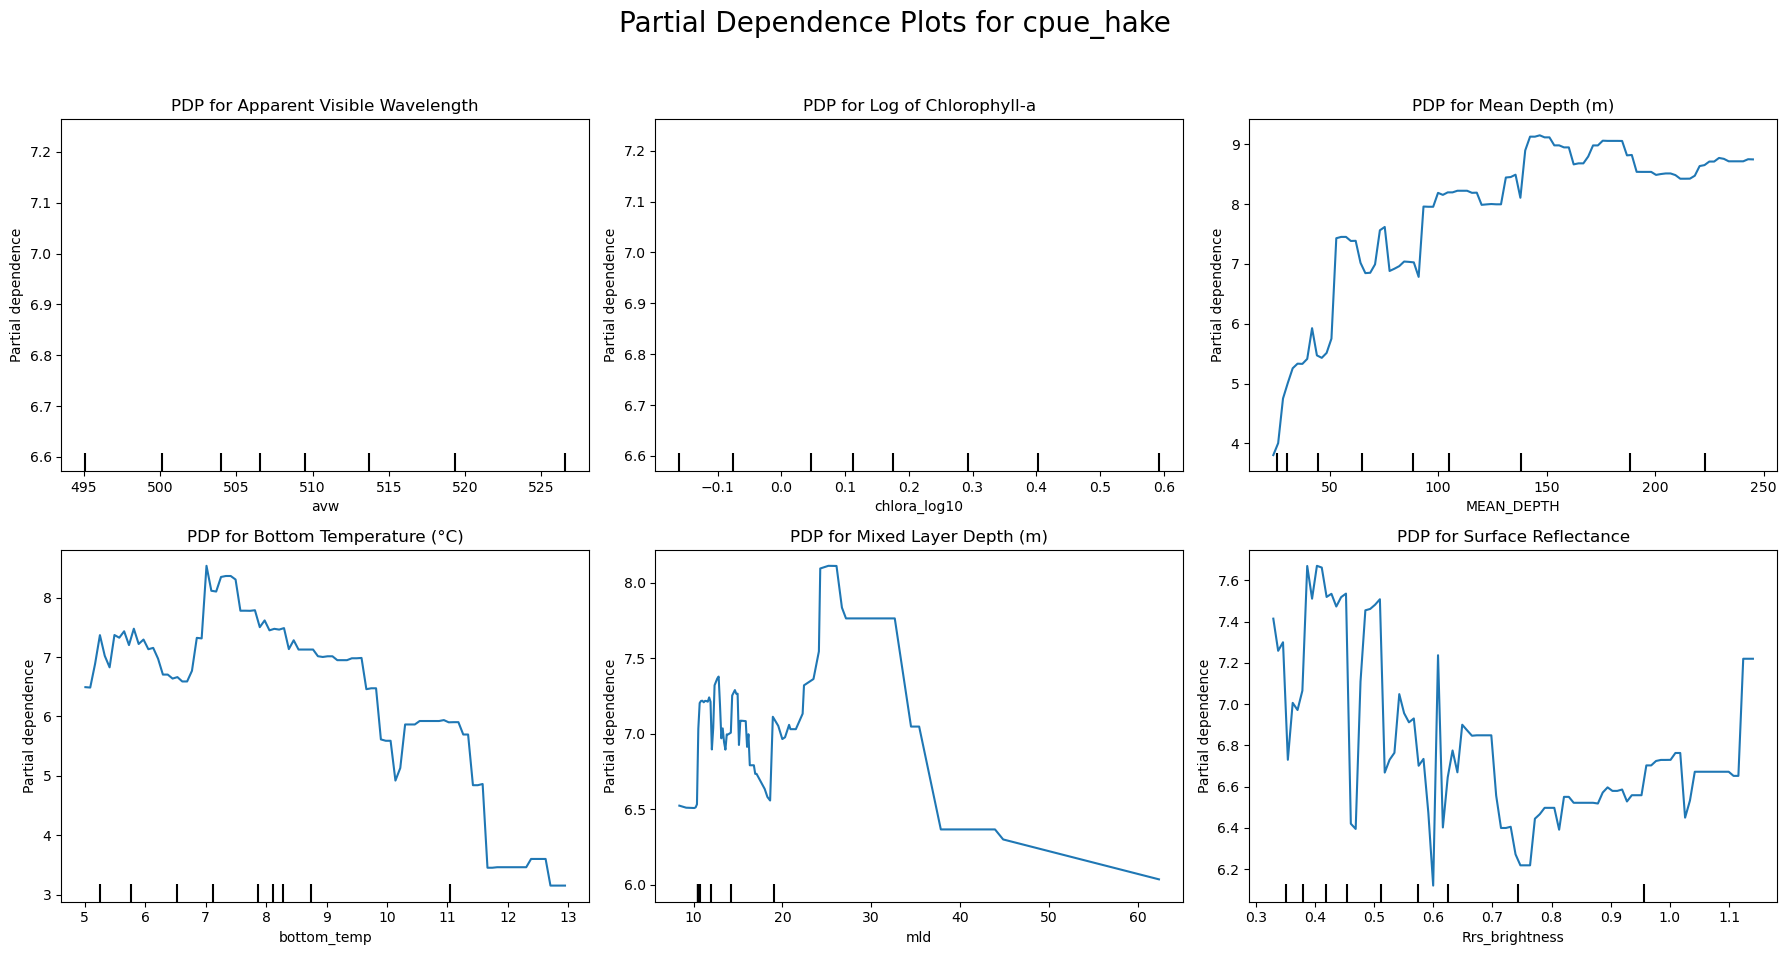


--- Generating PDP grid for: cpue_squid ---


/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


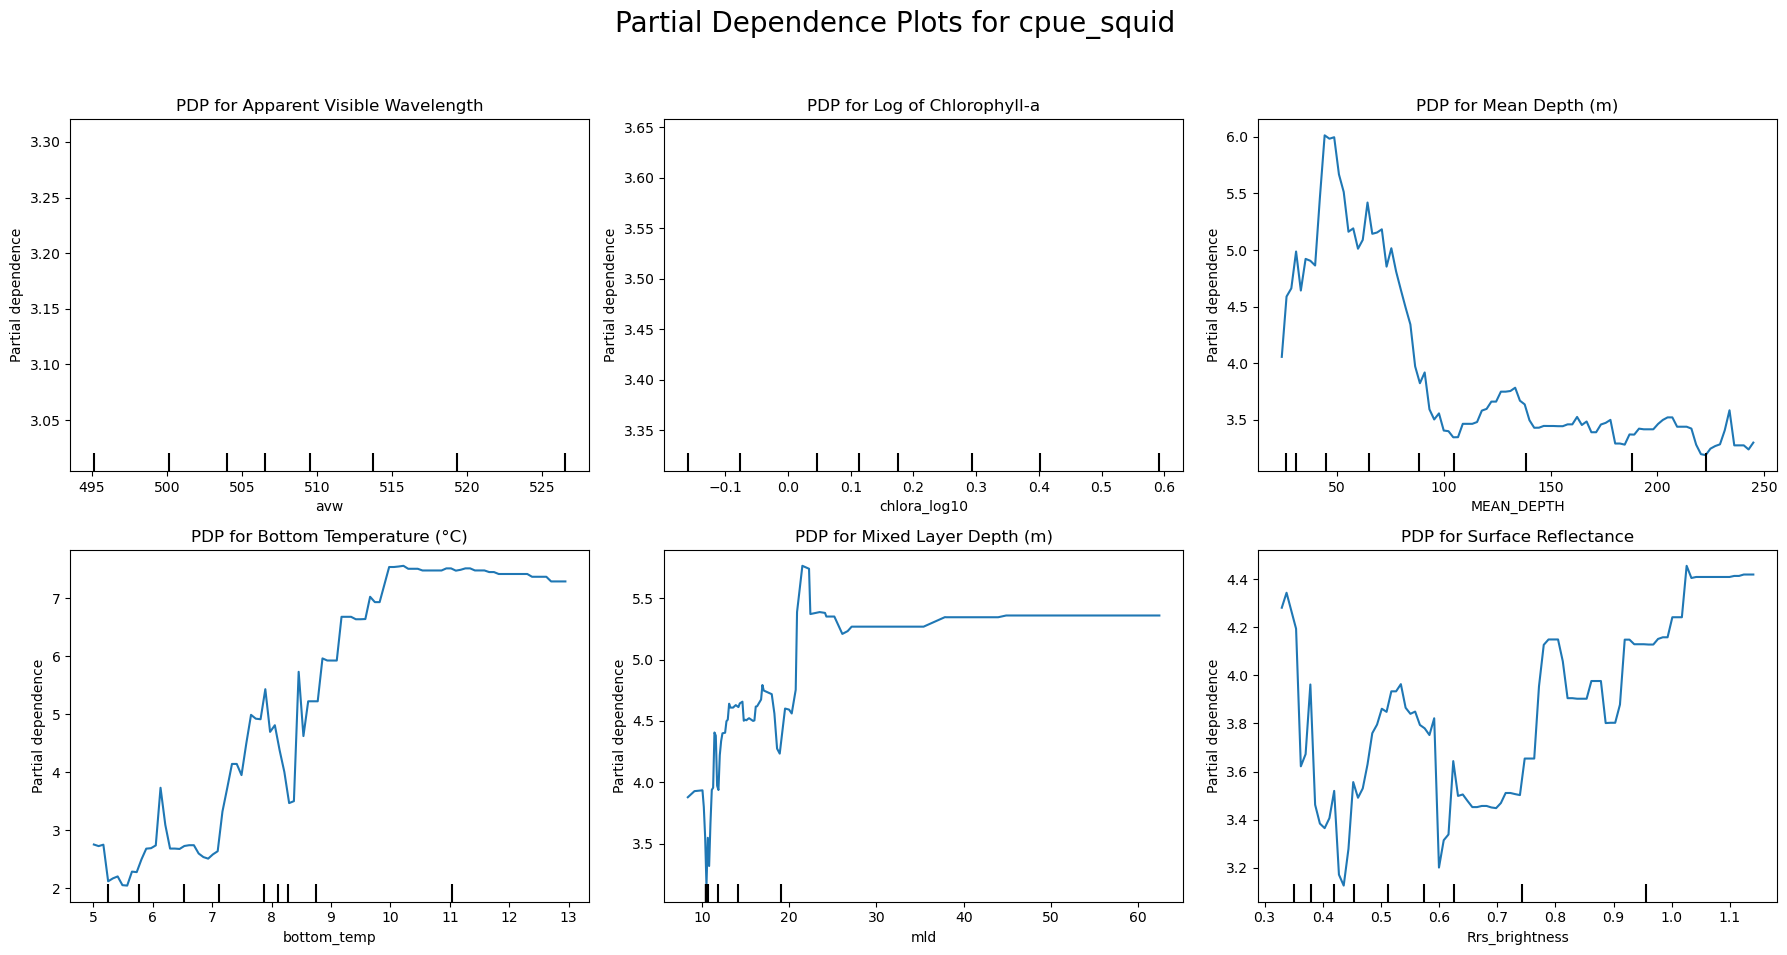


--- Generating PDP grid for: cpue_spot ---


/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


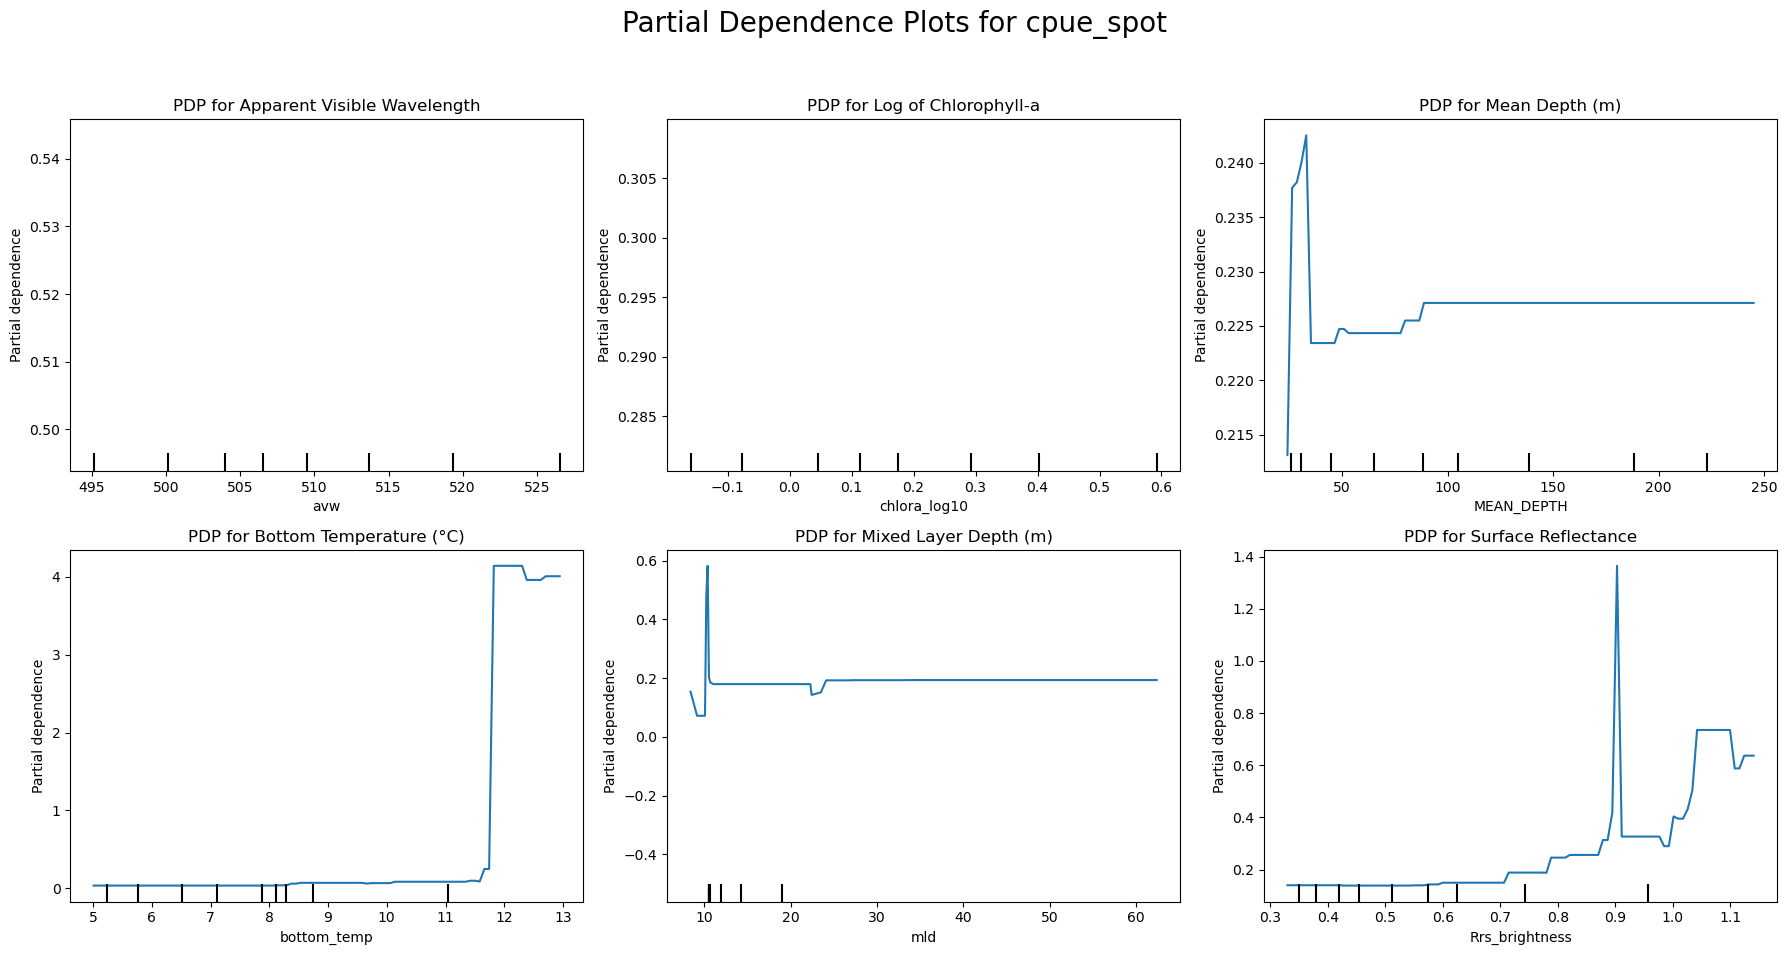

In [66]:
# --- Create readable names for the predictors ---
feature_name_map = {
    'avw': 'Apparent Visible Wavelength',
    'chlora_log10': 'Log of Chlorophyll-a',
    'MEAN_DEPTH': 'Mean Depth (m)',
    'bottom_temp': 'Bottom Temperature (°C)',
    'mld': 'Mixed Layer Depth (m)',
    'Rrs_brightness': 'Surface Reflectance'
}

# --- Create Partial Dependence Plots in a Grid ---
print(f"\n--- Creating Partial Dependence Plots for {TARGET_SPECIES} ---")

# Loop through each species to create a separate figure
for i, species in enumerate(TARGET_SPECIES):
    print(f"\n--- Generating PDP grid for: {species} ---")

    # 1. Create a figure with a 2x3 grid of subplots
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    axs = axs.flatten() # Flatten the 2D array of axes for easy iteration

    # 2. Loop through each predictor to place it on a subplot
    for j, predictor in enumerate(PREDICTOR_COLUMNS):
        if predictor in X_train.columns:
            try:
                ax = axs[j] # Select the correct subplot

                # Call the function WITHOUT the 'show' argument
                PartialDependenceDisplay.from_estimator(
                    estimator=xgb_reg,
                    X=X_train,
                    features=[predictor],
                    target=i,
                    ax=ax
                    # show=False 
                )

                # Use the readable name from the dictionary for the title
                ax.set_title(f"PDP for {feature_name_map.get(predictor, predictor)}")
                ax.set_ylabel("Partial Dependence")
                ax.grid(True, linestyle='--', alpha=0.6)

            except Exception as e:
                print(f"Could not create PDP for {predictor} and {species}. Error: {e}")
                ax.set_visible(False)

    # 3. Add a main title for the entire figure and adjust layout
    fig.suptitle(f"Partial Dependence Plots for {species}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # 4. Show the entire grid for the current species
    plt.show()

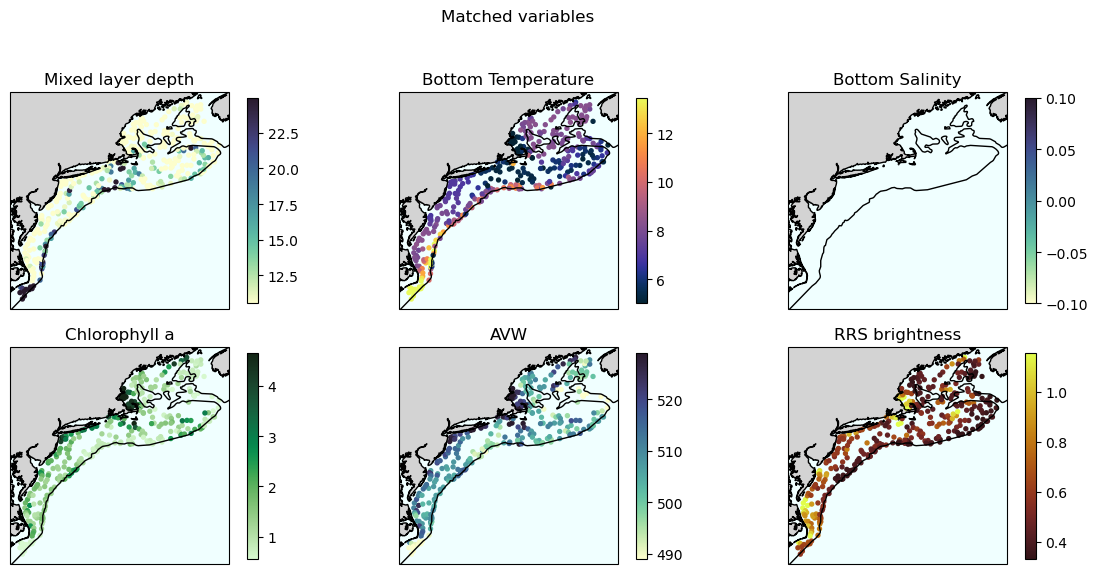

In [58]:
bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))
fig, axs = plt.subplots(2, 3, figsize=(12, 6), subplot_kw={'projection': cartopy.crs.PlateCarree()})

# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten()

var = ['mld', 'bottom_temp', 'bottom_salinity', 'chlor_a', 'avw', 'Rrs_brightness']
var_n = ['Mixed layer depth', 'Bottom Temperature', 'Bottom Salinity', 'Chlorophyll a', 'AVW', 'RRS brightness']

# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    valid_data = trawl_df[var[i]].dropna() # Drop NaN values for quantile calculation
    if not valid_data.empty:
        vmin = valid_data.quantile(0.05)
        vmax = valid_data.quantile(0.95)
    else:
        vmin, vmax = None, None # Handle cases where a column might be all NaN

    if var[i] == 'bottom_temp':
        cmap = cmocean.cm.thermal
    elif var[i] == 'chlor_a':
        cmap = cmocean.cm.algae
    elif var[i] == 'Rrs_brightness':
        cmap = cmocean.cm.solar
    else:
        cmap = cmocean.cm.deep

    im = ax.scatter(
        trawl_df.longitude,
        trawl_df.latitude,
        c=trawl_df[var[i]],
        label=var[i],
        s=8,
        cmap=cmap,
        vmin=vmin,  
        vmax=vmax  
    )
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1)
    ax.add_feature(cartopy.feature.LAND, facecolor='lightgrey')
    ax.add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, facecolor='azure')
    fig.colorbar(im, ax=ax, shrink=0.95)
    ax.set_title(var_n[i])

fig.suptitle('Matched variables')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [70]:
values = explainer.shap_values(X_val)

print(f"Type of the main SHAP variable: {type(values)}")
print(f"Number of target outputs found: {len(values)}")
print("---")
print(f"Shape of SHAP values for the FIRST target: {values[0].shape}")
print(f"Shape of the X_val DataFrame: {X_val.shape}")

# This check should return True
print(f"\nDo the number of rows match? {values[0].shape[0] == X_val.shape[0]}")

Type of the main SHAP variable: <class 'numpy.ndarray'>
Number of target outputs found: 74
---
Shape of SHAP values for the FIRST target: (6, 4)
Shape of the X_val DataFrame: (74, 6)

Do the number of rows match? False


In [ ]:
import shap
import matplotlib.pyplot as plt

# Calculate the SHAP values
values = explainer.shap_values(X_val)

# Let's verify the shape of the 3D array
print(f"Confirmed shape of SHAP values array: {values.shape}") # Should be (74, 6, 4)

# Loop through each target species by its index (0, 1, 2, 3)
for i, species in enumerate(TARGET_SPECIES):
    print(f"\n--- Generating SHAP Dependence Plot for: {species} ---")

    # Select the slice for the current species.
    shap_values_for_species = values[:, :, i]

    # Now, shap_values_for_species has the correct 2D shape: (74, 6)
    print(f"Shape of sliced SHAP values for {species}: {shap_values_for_species.shape}")

    # Create the dependence plot with the correctly shaped array
    shap.dependence_plot(
        "bottom_temp",                 # Feature for the x-axis
        shap_values_for_species,       # The correctly sliced 2D array
        X_val,                         # The feature data
        interaction_index="avw",       # Optional: feature to color by
        show=False
    )
    plt.title(f"SHAP Dependence for {species} vs. avw")
    plt.show()

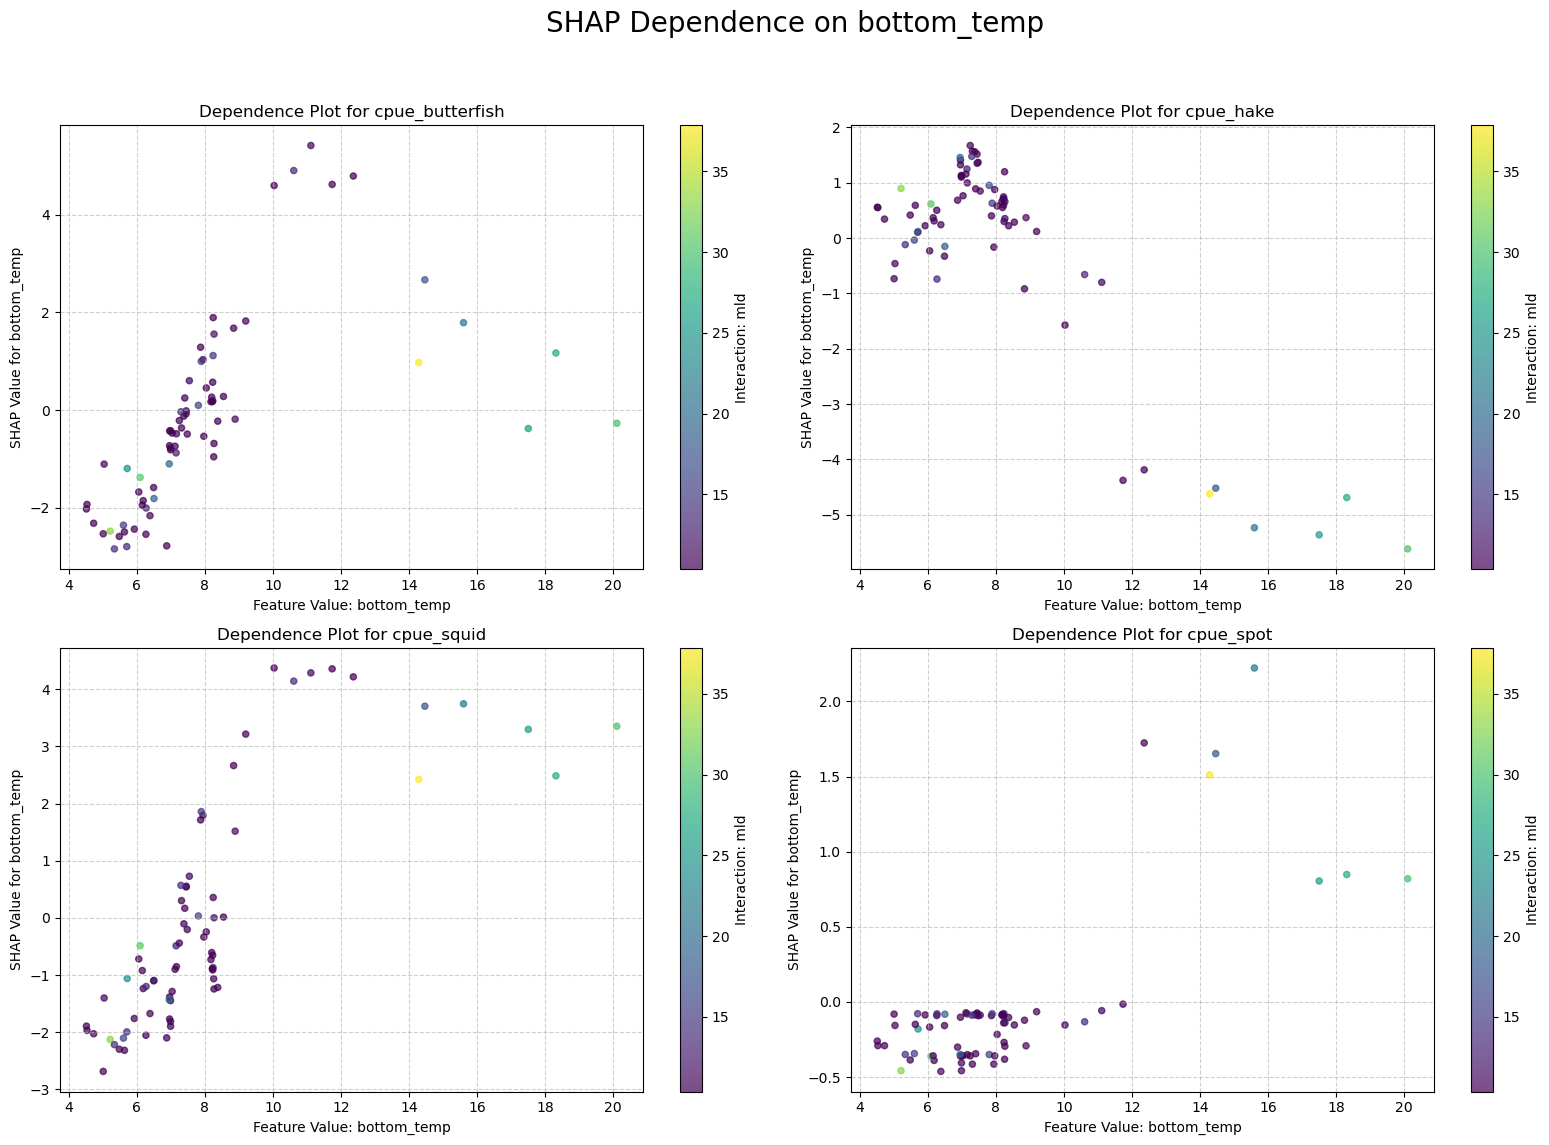

In [76]:
values = explainer.shap_values(X_val)

# --- SHAP Dependence Grid ---

# 1. Define the features you want to plot
feature_to_plot = "bottom_temp"
interaction_feature = "mld"

# 2. Create the 2x2 grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axs = axs.flatten()

# 3. Get the integer column index for your features. 
try:
    feature_idx = X_val.columns.get_loc(feature_to_plot)
except KeyError:
    print(f"Error: Feature '{feature_to_plot}' not in X_val columns!")
    # Handle error appropriately
    feature_idx = None

# 4. Loop through each species and draw the plot on the correct subplot
if feature_idx is not None:
    for i, species in enumerate(TARGET_SPECIES):
        ax = axs[i]

        # Slice the 3D SHAP array to get values for the current species
        shap_values_for_species = values[:, :, i]

        # Create the scatter plot directly on the subplot 'ax'
        scatter = ax.scatter(
            x=X_val.iloc[:, feature_idx],  # Use the index to get feature values
            y=shap_values_for_species[:, feature_idx], # Get SHAP values for that feature
            c=X_val[interaction_feature], # Use the interaction feature for color
            cmap='viridis',
            alpha=0.7,
            s=20 # Adjust point size if needed
        )

        # Add a colorbar for the interaction feature
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label(f"Interaction: {interaction_feature}")

        # Set titles and labels for the subplot
        ax.set_title(f"Dependence Plot for {species}")
        ax.set_xlabel(f"Feature Value: {feature_to_plot}")
        ax.set_ylabel(f"SHAP Value for {feature_to_plot}")
        ax.grid(True, linestyle='--', alpha=0.6)

# 5. Add a main title and display the single, completed figure
fig.suptitle(f"SHAP Dependence on {feature_to_plot}", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Step 9: Plotting Model Predictions at Survey Locations ---


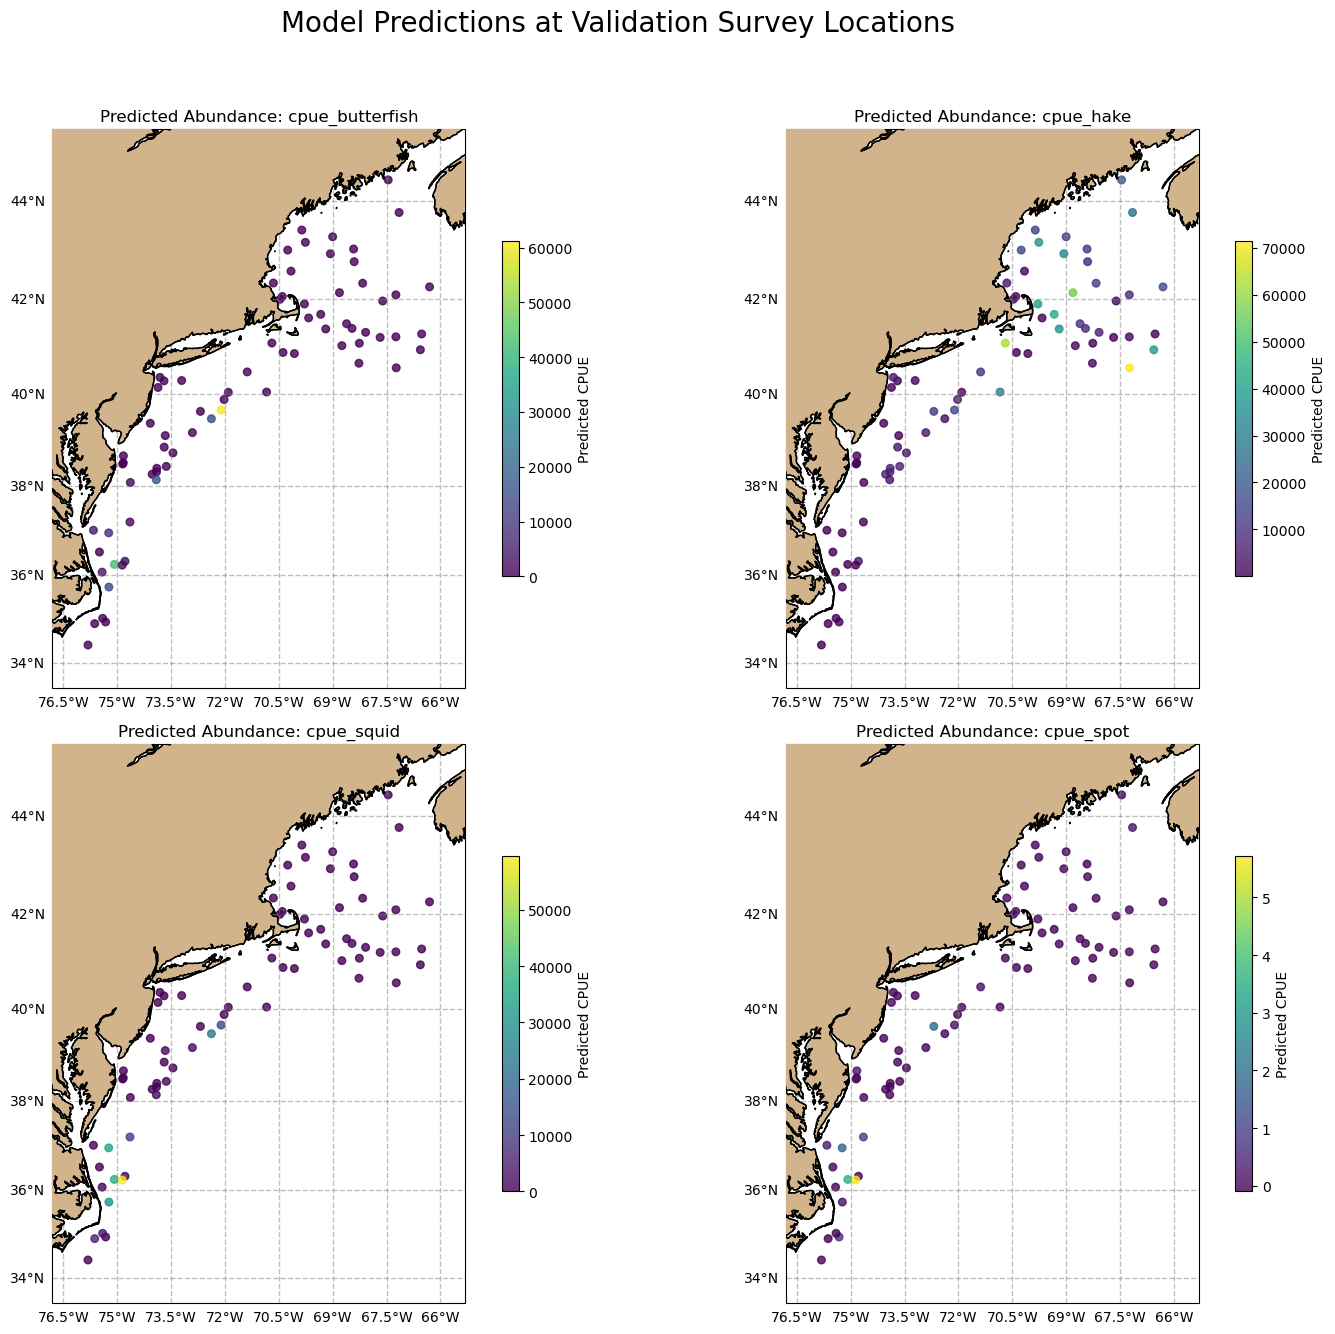

In [79]:
# 1. Get the model predictions for the validation set
# This gives you the predicted log-CPUE for each point in X_val
predictions_log = xgb_reg.predict(X_val)
# Convert back from log scale to the original CPUE scale
predictions_cpue = np.expm1(predictions_log)

# 2. Get the latitude and longitude for the validation points
val_coords = df.loc[X_val.index]

# 3. Create a 2x2 grid of maps
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(15, 14),
    subplot_kw={'projection': ccrs.Mercator()}
)
axs = axs.flatten()

for i, species in enumerate(TARGET_SPECIES):
    ax = axs[i] # Select the subplot for the current species

    # Set the geographic extent of the map based on your data
    ax.set_extent([
        val_coords['longitude'].min() - 1, val_coords['longitude'].max() + 1,
        val_coords['latitude'].min() - 1, val_coords['latitude'].max() + 1
    ], crs=ccrs.PlateCarree())

    # Add geographic features
    ax.add_feature(cfeature.LAND, zorder=5, edgecolor='black', facecolor='tan')
    ax.add_feature(cfeature.COASTLINE, zorder=5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Draw gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Create the scatter plot
    # x and y are the coordinates
    # c is the color, based on the prediction for the current species
    scatter = ax.scatter(
        x=val_coords['longitude'],
        y=val_coords['latitude'],
        c=predictions_cpue[:, i], # Select the prediction column for this species
        cmap='viridis',
        transform=ccrs.PlateCarree(),
        s=30, # Adjust point size
        alpha=0.8
    )

    # Add a colorbar for each subplot
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.6, orientation='vertical')
    cbar.set_label('Predicted CPUE')

    # Set the title for the subplot
    ax.set_title(f'Predicted Abundance: {species}')

# Add a main title for the entire figure
fig.suptitle('Model Predictions at Validation Survey Locations', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()